# What's new in Lightkurve v2?

## Lightkurve v2 improves support for TESS & other telescopes

---

Lightkurve v1.x has been a tremendous success.  Owing to the efforts of [67 contributors](https://github.com/KeplerGO/lightkurve/blob/master/AUTHORS.rst), Lightkurve grew into a popular tool to analyze the data archive of NASA's Kepler space telescope.  To date, the toolkit has been cited or mentioned by nearly [200 scientific publications](https://ui.adsabs.harvard.edu/search/q=full%3A"Lightkurve").

In recent years, the success revealed a shortcoming: Lightkurve v1.x was too narrowly focused on supporting Kepler data products. Over the past two years, our community has evolved in important ways:

* NASA successfully launched TESS, adding a significant new data set which requires Lightkurve-like tools.
* The data archive at MAST started hosting numerous alternative light curve databases created using specialized community pipelines.
* Many new time domain missions are on the horizon, including NASA's Roman Space Telescope.

In an effort led by the [TESS Guest Investigator Office](https://heasarc.gsfc.nasa.gov/docs/tess/) at NASA Goddard, **Lightkurve has been modified to better support TESS in three important ways**:


1. LightCurve objects are now specialized kinds of AstroPy Table objects, allowing data to be loaded from any telescope.
2. Data search functions now support all TESS and Kepler light curve available at MAST, including those created by community pipelines.
3. The noise removal tools now allow users to reproduce and tune the same correction methods in use by NASA's official Kepler/TESS pipeline.

The remainder of this document demonstrates these new features.


## 1. LightCurve objects are now specialized kinds of AstroPy Tables
---

The most important change in Lightkurve v2 is that light curves are now extensions of the AstroPy [TimeSeries](https://docs.astropy.org/en/stable/timeseries/) object, which in turn is a sub-class of AstroPy's Table class.
Compared to a generic table, the key difference is that each `LightCurve` object is guaranteed to have `time`, `flux`, and `flux_err` columns. This allows the object to provide tools that are specific to the manipulation of TESS-like time series photometry.

### ✨ New: LightCurve objects look and act like tables

Light curves can still be created as before, but appear as tables:

In [1]:
from lightkurve import LightCurve
lc = LightCurve(time=[2000.0, 2000.1, 2000.2],
                flux=[1.0, 1.0, 1.0],
                flux_err=[0.1, 0.1, 0.1],
                time_format="btjd")
lc

time,flux,flux_err
,,
object,float64,float64
2000.0,1.0,0.1
2000.1,1.0,0.1
2000.2,1.0,0.1


### ✨ New: Light curves can contain user-defined columns

Because light curves are now tables, they can contain arbitrary user-defined columns:

In [2]:
lc['color'] = ['red', 'green', 'blue']
lc

time,flux,flux_err,color
,,,
object,float64,float64,str5
2000.0,1.0,0.1,red
2000.1,1.0,0.1,green
2000.2,1.0,0.1,blue


### ✨ New: Columns and rows can be accessed using index notation

In the same way as for Table objects, columns and rows can be accessed using index notation:

In [3]:
lc[1:3]

time,flux,flux_err,color
,,,
object,float64,float64,str5
2000.1,1.0,0.1,green
2000.2,1.0,0.1,blue


In [4]:
lc['flux']

<Quantity [1., 1., 1.]>

### ✨ New: The time column is an AstroPy Time object




In [5]:
lc.time

<Time object: scale='tdb' format='btjd' value=[2000.  2000.1 2000.2]>

In [6]:
lc.time.iso

array(['2020-05-30 12:00:00.000', '2020-05-30 14:24:00.000',
       '2020-05-30 16:48:00.000'], dtype='<U23')

### ✨ New: read and write light curve in a range of formats

Because they are tables, light curves now have easy `read()` and `write()` methods which allow a [variety of data formats](https://docs.astropy.org/en/stable/io/unified.html#built-in-readers-writers) to be used.  For example, it is now much easier to read and write a light curve to a human-readable text file:

In [7]:
lc.write("/tmp/lightcurve.txt", format="ascii.fixed_width", overwrite=True)
!cat /tmp/lightcurve.txt

|   time | flux | flux_err | color |
| 2000.0 |  1.0 |      0.1 |   red |
| 2000.1 |  1.0 |      0.1 | green |
| 2000.2 |  1.0 |      0.1 |  blue |


In [8]:
LightCurve.read("/tmp/lightcurve.txt", format="ascii.fixed_width")

time,flux,flux_err,color
,,,
object,float64,float64,str5
2000.0,1.0,0.1,red
2000.1,1.0,0.1,green
2000.2,1.0,0.1,blue


## 2. Improved data access from MAST
---

Lightkurve v2 significantly improves searching and downloading data from the TESS & Kepler data archive at MAST.

### ✨ New: Search operations support different TESS pipelines

The search operations now support all the Kepler & TESS light curves available from the data archive at MAST, including community-contributed light curves. Click on the value in the `author` column to learn more about a given data product. As an added bonus, the search and download operations are now *much* faster owing to improved caching.

In [1]:
import lightkurve as lk
lk.search_lightcurve("AU Mic")

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,441420236,0.0
1,TESS Sector 01,2018,TASOC,120,441420236,0.0
2,TESS Sector 01,2018,TASOC,1800,441420236,0.0
3,TESS Sector 27,2020,SPOC,20,441420236,0.0
4,TESS Sector 27,2020,SPOC,120,441420236,0.0
5,TESS Sector 27,2020,TESS-SPOC,600,441420236,0.0


### ✨ New: TESS fast cadence data is now supported

The TESS mission recently introduced a new 20-second exposure time mode ("fast cadence") and decreased the exposure time of its Full Frame Images to 10 minutes.  In response, Lightkurve now allows user to specify the exact exposure time via the optional ``exptime`` argument.

In [2]:
lk.search_lightcurve("AU Mic", exptime=20)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 27,2020,SPOC,20,441420236,0.0


In [3]:
result = lk.search_lightcurve("AU Mic", exptime=20)
r = result[result.exptime.value < 100]

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

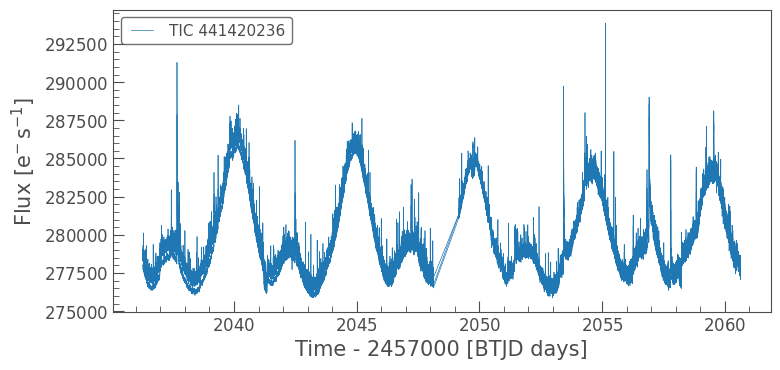

In [25]:
lk.search_lightcurve("AU Mic", sector=27).download_all().plot()

### ✨ New: remove systematics from light curves using the official Cotrending Basis Vectors


In [83]:
lc.to_corrector("cbv")

ValueError: Unrecognized method 'cbv'
allowed methods are: ['sff']

## 3. Improved data manipulation methods

### ✨ New: use *plot_pixels()* to inspect pixel-by-pixel light curves

A new ``TargetPixelFile.plot_pixels()`` method has been added which enables the light curves and periodograms of individual pixels to be inspected within a pixel file.

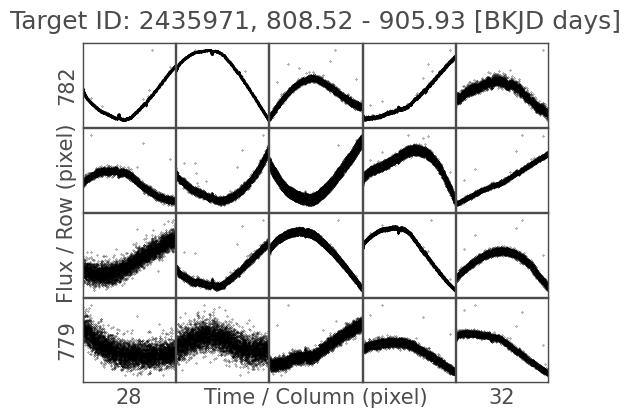

In [67]:
pixelfile = lk.search_targetpixelfile('KIC 2435971', mission='Kepler', quarter=9).download()
pixelfile.plot_pixels();

### ✨ New: different data columns can now be plotted

The plotting methods now accept an optional ``column`` parameter to enable any column in a light curve to be plotted:

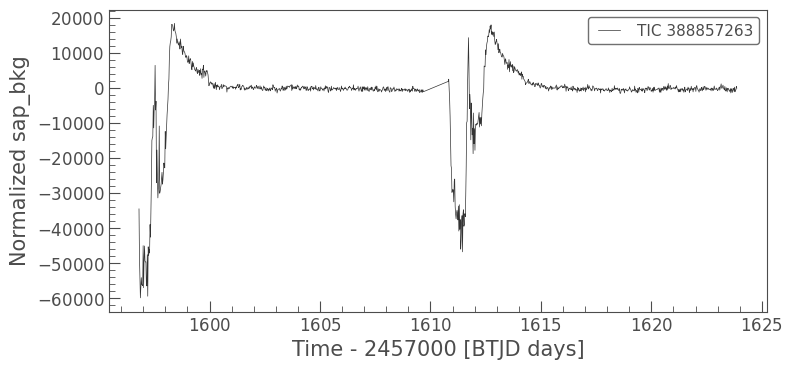

In [70]:
lc = lk.search_lightcurve("Proxima Centauri")[0].download()
lc.plot(column="sap_bkg");

In [58]:
lc.search_neighbors()

AttributeError: object has no attribute ra



* New tutorials

* - Modified ``plot()`` to use a more clear hatched style when visualizing the
  aperture mask on top of pixel data. [#814]


* - Added the ``LightCurve.search_neighbors()`` convenience method to search for
  light curves around an existing one. [#907]

* CBVCorrector
* - Added a ``metrics`` module with two functions to measure the degree of
  over- and under-fitting of a corrected light curve. [#907

## Full change log

To see a detailed list of all changes, please see the [Full Changelog]().

## Contributors to the v2.0 release

People who have contributed to this release include:
...

## Will existing Lightkurve code break?

While we try to maintain a high degree of backwards compatibility with Lightkurve v1.x, it looks like nine API changes are unavoidable:


* Removed support for Python 2

### LightCurve.flux is now an AstroPy Quantity object

2. **All other columns are now Astropy Quantity objects.** Most numpy/scipy functions can deal with these, but you will nevertheless have to use `lc.flux.value` at times.


### LightCurve objects can have arbitrary columns

## LightCurve meta data is now stored in the `meta` dictionary

Consistent with AstroPy Table objects,

3. **All metadata is now stored in the lc.meta dictionary**, including all FITS header values.  For convenience, we support attribute access, e.g. `lc.sector` resolves to `lc.meta['sector']`, but the use of the latter is encouraged because not every light curve will have a sector keyword.


## LightCurveFile classes have been removed

4. **LightCurveFile classes have been removed.** Instead, files must now be loaded using `lightkurve.read(filename, flux_column="pdcsap_flux", quality_bitmask="default")`.



### Demo

https://colab.research.google.com/drive/1YA7Jni9ekzmOglg3qRs_tOnBXnFSJtjq?usp=sharing



6. **lc.bin() now takes time_bin_size and time_bin_start arguments.** This is for consistency with `astropy.timeseries.aggregate_downsample`. This significantly alters the behavior of binning, because bins are now defined in time instead of by number of data points.
7. **lc.fold() now returns un-normalized phase values by default.**  This is for consistency with `TimeSeries.fold()`. For the same reason, the `t0` argument has been deprecated in favor of `epoch_time`, and the method now accepts the extra `epoch_phase`, `wrap_phase`, and `normalize_phase` arguments.



## How do I install Lightkurve v2.0?



In [ ]:
A decision has been made to transform our `LightCurve` object into a sub-class of AstroPy's `TimeSeries` object. This allows Lightkurve to build upon the generic, table-like data structure provided by AstroPy and focus more strongly on providing features that are specific to time resolved CCD photometry from mission such as TESS and Kepler.

Three major benefits of this change are:

1. `LightCurve` objects can now contain arbitrary data columns.
2. Multiple light curve data formats are now supported via the generic `LightCurve.read()` and `LightCurve.write()` methods, which build upon AstroPy's `Table.read()` and `Table.write()` functions.
3. `LightCurve` objects now leverage AstroPy `Time` objects to store the `time` column and AstroPy `Quantity` objects for all other columns. This enables us to support different time formats and data units in a generic way.



### How does Lightkurve's `LightCurve` differ from AstroPy's `TimeSeries`?

A `TimeSeries` object is a table which is guaranteed to have a special `time` column, which is always the first column and guaranteed to be an AstroPy `Time` object. `LightCurve` extends this concept by also adding special `flux` and `flux_err` columns, which are always the second and third column.  These dedicated columns enable us to provide extra methods which are specific to the manipulation of brightness data obtained by imaging photometry.  Some of these methods may eventually be migrated to `TimeSeries` if they are sufficiently generic and mature, but many methods that are specific Kepler/TESS-like data sets will likely remain in `LightCurve` to avoid overwhelming AstroPy with mission-specific details.

### ✨ New: other numerical columns are now AstroPy Quantity objects

Offering convenient access to units.

In [70]:
lc.flux

<Quantity [1., 1., 1.] electron / s>

In [71]:
lc.flux.unit

Unit("electron / s")